<img src="https://www.anped.org.br/sites/default/files/images/ufcg-lateral.png" width="780" height="240" align="center"/>

## Centro de Engenharia Elétrica e Informática
## Departamento de Engenharia Elétrica
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Veloso
## Aluno(a): William Henrique A. Martins

# Experimento 07.1: Classificação de Dígitos com Redes Neurais Artificiais

In [21]:
import os                                              # Operational System para manipulação de arquivos.
import cv2                                             # OpenCV para manipulação de imagens.
import numpy as np                                     # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                        # Pyplot para plotagem de gráficos e imagens.
from sklearn.model_selection import train_test_split   # Função para particionamento dos dados

from tensorflow.keras.models import Sequential         # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.layers import Dense, Input       # Camada de neurônios densamente conectados.
from tensorflow.keras.optimizers import Adam           # Otimizador "Descida do Gradiente com Momento".
from tensorflow.keras.utils import to_categorical      # Função para preprocessamento dos gabaritos.
from tensorflow.keras.callbacks import ModelCheckpoint # Callback que salva o modelo durante o treinamento

from tensorflow.keras.datasets import mnist            # Dataset utilizado nesse experimento.

## 1. Banco de Dados

* Vamos utilizar o MNIST, outro banco de dados presente no catálogo de datasets do Keras, que é disponibilizado como uma função pronta;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um dígito manuscrito;

* As imagens do banco de dados são monocromáticas e de dimensões 28 x 28;

* Os gabaritos correspondem ao número manuscrito, sendo um inteiro entre 0 e 9;

* O banco de dados contém 60.000 imagens para treino e 10.000 imagens para teste;

### 1.1 Organização do banco de dados

* Como vimos, a primeira dimensão dos arrays do banco de dados é reservada para controlar a amostra e as demais correspondem às demais dimensões do tipo de dados utilizado. 

* Nesse caso, os nossos dados são imagens monocromáticas (2D), de modo que são organizados em tensores tridimensionais (3D) com formato: **dados.shape = (amostras, altura, largura)**
    * O i-ésimo exemplo pode ser acessado a partir de: **exemplo = dados[i]**
    * Um pedaço de uma imagem pode ser acessado de forma similar:
        * Quadrante superior esquerdo da i-ésima imagem: **quad = dados[i, :14, :14]**
        

* O banco de dados pode ser carregado utilizando:
    * **(train_data, train_targets), (test_data, test_targets) = mnist.load_data()**
    * train_data é um tensor com as entradas do conjunto de treino;
    * test_data é um tensor com as entradas do conjunto de teste;
    * train_targets é um tensor com os gabaritos do conjunto de treino;
    * test_targets é um tensor com os gabaritos do conjunto de teste;

In [22]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

**a. O código abaixo plota alguns exemplos aleatórios do banco de dados e verifica algumas das suas propriedades.**

* Verifique alguns exemplos do banco de dados e suas propriedades.
* O quão semelhantes as amostras de um mesmo dígito são entre si?
<font color='green'>
As amostras são semelhantes em rótulos, mas existem diversas maneiras de se representar o mesmo digito a depender da caligráfia.
</font>
* Os gabaritos estão sempre de acordo com as imagens?
<font color='green'>
Caso não estiverem, o banco de dados contém erros que serão propagados para a rede durante o treinamento.
</font>
* Desenvolver um algoritmo baseado em PDI para classificar esses dígitos seria uma tarefa simples? Quais seriam as principais dificuldades?
<font color='green'>
Não, seria uma tarefa complexa. As principais dificuldades seriam a caracterização de cada digito entre 0 e 9, todas essas caracteristicas deveriam estar explicitadas no algoritmo.
</font>

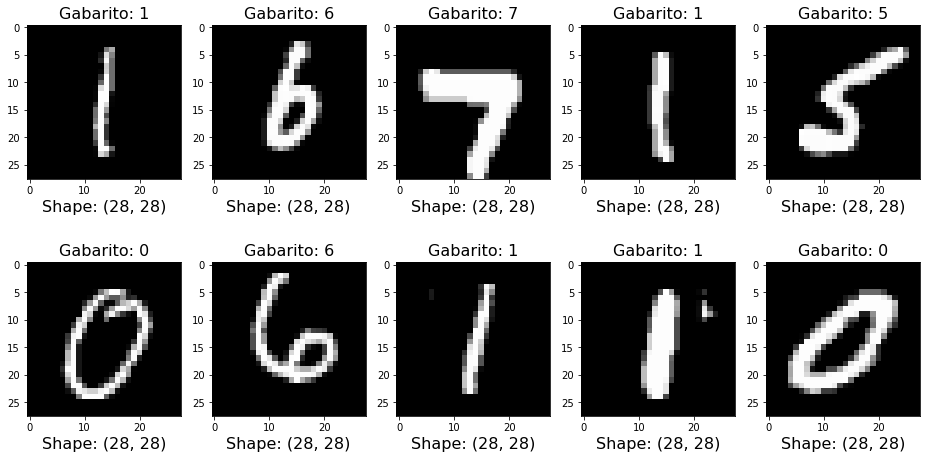

In [23]:
# Escolhe exemplos aleatórios
indices = np.random.randint(0, 60000-1, 10)

# Plots
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 8))

for i, idx in enumerate(indices):
    
    # Plota a imagem
    axs[i//5][i%5].imshow( train_images[idx], vmin=0, vmax=255, cmap="gray" )
    
    # Adiciona o gabarito como título
    axs[i//5][i%5].set_title( "Gabarito: {}".format(train_labels[idx]), fontsize = 16 )
    
    # Adiciona o shape como subtítulo
    axs[i//5][i%5].set_xlabel( "Shape: {}".format(train_images[idx].shape), fontsize = 16 )

**b. Utilize a função np.unique() para verificar os possíveis gabaritos em train_labels e test_labels.**

* https://numpy.org/doc/stable/reference/generated/numpy.unique.html

In [25]:
train_unique = np.unique(train_labels)
test_unique = np.unique(test_labels)

print("Gabarito de treino: {}\n Gabarito de Teste: {}".format(train_unique, test_unique))

Gabarito de treino: [0 1 2 3 4 5 6 7 8 9]
 Gabarito de Teste: [0 1 2 3 4 5 6 7 8 9]


### 1.2 Pre-processamento dos dados de entrada

* Como estamos utilizando Redes Neurais Artificiais não podemos utilizar as imagens em formato de matriz, precisamos que a entrada seja seja um vetor de características.

* Para isso, podemos utilizar a função **reshape(shape)** que reorganiza um array para um determinado formato especificado desde que seja possível alocar todos os valores do array original para o novo formato.

* Além disso, como em uma imagem todos os pixels são valores entre 0 e 255, podemos pre-processar os dados de entrada a partir de uma simples divisão por 255, que garante que todos os dados estarão entre 0 e 1.

In [26]:
def preprocess_data(data):
    # Desfaz a matriz da imagem e reorganiza os dados como um vetor
    data = data.reshape((len(data), 28 * 28))
    # Normaliza os valores ao dividir pelo maior valor possível dentro das imagens.
    data = data.astype("float32")/255
    return data

train_vectors = preprocess_data(train_images)
test_vectors  = preprocess_data(test_images)

**c. Verifique as dimensões e a faixa de valores dos dados de treino e teste após o pré-processamento. Não é necessário verificar a faixa de valores para cada característica isoladamente.**

In [9]:
print("Novos formatos \n -Treino: {} \n - Validação: {}".format(train_vectors.shape, test_vectors.shape))

Novos formatos 
 -Treino: (60000, 784) 
 - Validação: (10000, 784)


<font color='green'>
Percebe-se que o formato é ( Numero de Amostras, Quantidade de Pixels)
</font>

### 1.3 Particionamento dos dados de treino

* Agora vamos criar uma partição de validação a partir do conjunto de treino para realizar uma validação cruzada. 

* Novamente vamos utilizar a função **train_test_split**, que separa dados e os seus respectivos gabaritos segundo uma fração especificada.

* Contudo, dessa vez utilizaremos o parâmetro **stratify**, que indica os rótulos associados aos dados fornecidos. Quando esse parâmetro é fornecido a função realiza o particionamento dos dados e mantém a proporção entre exemplos de uma mesma classe com relação aos dados originais.

**d. O código abaixo mostra a distribuição dos dados em um conjunto de gabaritos. Comente o que cada linha do programa faz.**

In [27]:
def print_label_percentage( labels ):
    unique, counts = np.unique( labels, return_counts = True) # retorna um conjunto de elementos unicos, e a frequência com que cada elemento ocorre
    for u, c in zip(unique, counts): # itera em conjunto dois arrays de mesma dimensão
        print( "\tGabarito {}: {} ({:.2f}%)".format( u, c, 100 * c / labels.shape[0] )) # calcula a distribuição de classes em % do conjunto passado 
    return

print("Treino:")
print_label_percentage( train_labels )

Treino:
	Gabarito 0: 5923 (9.87%)
	Gabarito 1: 6742 (11.24%)
	Gabarito 2: 5958 (9.93%)
	Gabarito 3: 6131 (10.22%)
	Gabarito 4: 5842 (9.74%)
	Gabarito 5: 5421 (9.04%)
	Gabarito 6: 5918 (9.86%)
	Gabarito 7: 6265 (10.44%)
	Gabarito 8: 5851 (9.75%)
	Gabarito 9: 5949 (9.91%)


**e. As classes do banco de dados são balanceadas? O train_test_split conseguiu manter as mesmas proporções entre as classes que os dados originais?**

<font color='green'>
Sim, podemos deduzir apartir da saída do bloco anterior que a média está em torno dos 10%.
</font>

In [28]:
# Fração escolhida para separar o mesmo número de instâncias do conjunto de testes
data_frac = test_vectors.shape[0] / train_vectors.shape[0]

# Criação do conjunto de validação
train_vectors, val_vectors, train_labels, val_labels = train_test_split(train_vectors,           # Dados de treino
                                                                        train_labels,            # Gabaritos de treino
                                                                        test_size = data_frac,   # Proporção de dados p/ validação
                                                                        stratify = train_labels, # Dados de referência
                                                                        random_state=42)         # Semente para garantir consistencia nos resultados

print("Treino:", train_vectors.shape, train_labels.shape)
print_label_percentage( train_labels )

print("\n\n")
print("Validação:", val_vectors.shape, val_labels.shape)
print_label_percentage( val_labels )

Treino: (50000, 784) (50000,)
	Gabarito 0: 4936 (9.87%)
	Gabarito 1: 5618 (11.24%)
	Gabarito 2: 4965 (9.93%)
	Gabarito 3: 5109 (10.22%)
	Gabarito 4: 4868 (9.74%)
	Gabarito 5: 4517 (9.03%)
	Gabarito 6: 4932 (9.86%)
	Gabarito 7: 5221 (10.44%)
	Gabarito 8: 4876 (9.75%)
	Gabarito 9: 4958 (9.92%)



Validação: (10000, 784) (10000,)
	Gabarito 0: 987 (9.87%)
	Gabarito 1: 1124 (11.24%)
	Gabarito 2: 993 (9.93%)
	Gabarito 3: 1022 (10.22%)
	Gabarito 4: 974 (9.74%)
	Gabarito 5: 904 (9.04%)
	Gabarito 6: 986 (9.86%)
	Gabarito 7: 1044 (10.44%)
	Gabarito 8: 975 (9.75%)
	Gabarito 9: 991 (9.91%)


### 1.4 Pre-processamento dos gabaritos

* Nesse caso temos um problema multiclasse com 10 classes, sendo elas correspondentes aos números entre 0 e 9. Consequentemente, o modelo produzido terá 10 unidades de saída, uma para cada classe, e utilizará a função de ativação softmax.

* Para fornecer esses gabaritos para a rede durante o treinamento é necessário categorizar as saídas, para limitá-las ao intervalo [0, 1]. Para isso vamos utilizar a função to_categorical() disponível no próprio Keras.

In [29]:
categorical_train_labels = to_categorical(train_labels)
categorical_val_labels = to_categorical(val_labels)
categorical_test_labels = to_categorical(test_labels)

**d. O código abaixo mostra alguns exemplos da transformação realizada pela função to_categorical(). Analise os exemplos e explique, o que a função faz?.**

In [ ]:
<font color='yellow'>
O código abaixo transforma os gabaritos em do modelo em um conjunto representativo, por exemplo,
o algoritmo vai utilizar este formato [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] para informar que a saída 
foi correspondente o número 1. Como o modelo possui 10 saídas, o array de saída representativo também deverá possuir 10 espaços.
</font>

In [30]:
# Escolhe exemplos aleatórios
indices = np.random.randint(0, categorical_train_labels.shape[0]-1, 10)

# Printa exemplos selecionados
for i, idx in enumerate(indices):
    categorical_example = categorical_train_labels[idx]
    non_categorical_example = train_labels[idx]
    print("{} -> {}".format(non_categorical_example, categorical_example))

1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
8 -> [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
8 -> [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 1.5 Construindo o modelo

Para construir o modelo usaremos a classe **Sequential**, que possibilita a construção de modelos sequenciais de forma bastante simples.
* A construção do modelo é feita a partir do seu instanciamento como objeto da classe seguido de chamadas à função **add()** para adicionar camadas.
* Como estamos construindo apenas Redes Neurais Artificiais por enquanto, vamos utilizar apenas as camadas **Dense** e **Input**.
    * A camada Input cria a entrada da rede com **Input( shape )**
        * shape corresponde ao formato do tensor de entrada, no nosso caso será o número de características do nosso banco de dados (13);
    * A camada Dense pode ser chamada com **Dense( n_unidades, activation = 'linear' )**
        * n_unidades corresponde ao número de neurônios da camada;
        * activation corresponde à função de ativação utilizada na camada;
* Algumas funções de ativação disponíveis são:
    * "linear"
    * "relu"
    * "sigmoid"
    * "softmax"
    * "tanh"


* Mais informações sobre a camada dense podem ser vistas em **https://keras.io/api/layers/core_layers/dense/**
* Mais informações sobre as ativações disponíveis podem ser vistas em **https://keras.io/api/layers/activations/**

**e. Nesse caso utilizamos uma saída com ativação linear. Qual seria a desvantagem de utilizar esse tipo de ativação nas demais camadas?**

<font color='green'>
Obteriamos um sistema no qual os pesos das demais camadas não seriam relevantes para o algoritmo, já que os conjuntos seriam combinações lineares dos demais.
</font>

In [31]:
def build_model( n_inputs, n_outputs ):
    rede = Sequential()
    rede.add( Input( (n_inputs, ) ) )
    rede.add( Dense(  128, activation = "relu") )
    rede.add( Dense(  256, activation = "relu") )
    rede.add( Dense( n_outputs, activation = "softmax" ) )
    return rede

model = build_model( 28*28, 10 )
model.compile( optimizer = Adam( learning_rate = 5e-4 ), 
               loss="categorical_crossentropy", 
               metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
_________________________________________________________________


* Dessa vez utilizaremos uma das callbacks do Keras, o Model_Checkpoint.
* Essa função salva o modelo conforme o treinamento é executado à medida que os valores da variável monitorada melhoram, preservando sempre o modelo com os melhores valores obtidos.
* model_checkpoint = ModelCheckpoint( path, monitor = None, save_best_only = True, verbose = 1)
    * path é o caminho para o salvamento do modelo;
    * monitor é a variável que deve ser monitorada pelo callback;
    * save_best_only indica se só o melhor modelo deve ser salvo ou se todos os aumentos devem ser salvos;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;

In [33]:
model_checkpoint = ModelCheckpoint("model.h5", monitor = "val_acc", save_best_only = True, verbose = 1)

### 1.6 Treinando o modelo

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize).

* **hist = model.fit( x = None, y = None, epochs = 1, batchsize = None, callbacks = [], validation_data = None, verbose = "auto")**
    * x corresponde aos dados de treino;
    * y corresponde aos gabaritos de treino;
    * epochs corresponde ao número de épocas de treinamento;
    * batchsize corresponde ao tamanho dos lotes entregues à rede de cada vez;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde a uma tupla ( val_data, val_targets ) com os dados de validação;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;
    
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [35]:
print(categorical_train_labels.shape)

(50000, 10)


In [34]:
history = model.fit( train_vectors, categorical_train_labels, epochs=10, batch_size=128, callbacks = [model_checkpoint], 
                    validation_data = (val_vectors, categorical_val_labels))
history_dict = history.history

Epoch 1/10
391/391 [==============================] - 3s 6ms/step - loss: 0.4300 - acc: 0.8798 - val_loss: 0.2147 - val_acc: 0.9380

Epoch 00001: val_acc improved from -inf to 0.93800, saving model to model.h5
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 0.1701 - acc: 0.9508 - val_loss: 0.1515 - val_acc: 0.9559

Epoch 00002: val_acc improved from 0.93800 to 0.95590, saving model to model.h5
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 0.1211 - acc: 0.9645 - val_loss: 0.1250 - val_acc: 0.9639

Epoch 00003: val_acc improved from 0.95590 to 0.96390, saving model to model.h5
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0938 - acc: 0.9721 - val_loss: 0.1126 - val_acc: 0.9658

Epoch 00004: val_acc improved from 0.96390 to 0.96580, saving model to model.h5
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.0752 - acc: 0.9776 - val_loss: 0.1015 - val_acc: 0.9697

Epoch 00005: val_a

# Plots

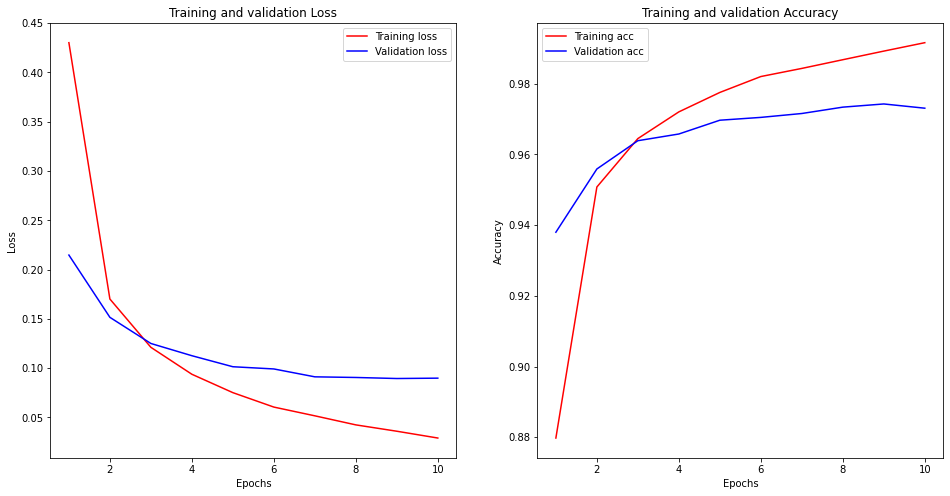

In [36]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

### 1.7 Teste

O teste do modelo pode ser realizado a partir da função **evaluate**, que recebe os dados de treino e retorna o valor de loss calculado para esse conjunto e os valores de cada métrica da lista fornecida durante a compilação do modelo. 

* É uma prática comum realizar ajustes no modelo com base no conjunto de validação e só utilizar o conjunto de testes após a definição dos hiperparâmetros definitivos.
* Como os hiperparâmetros são ajustados a partir dos resultados obtidos para o conjunto de validação, o modelo pode acabar. sobreajustando aos dados de validação, então é interessante mudar os dados desse conjunto com frequência.
* Para mudar os dados de validação basta alterar a semente na função train_test_split.
* Crie um novo modelo do zero após a realização de mudanças nos conjuntos de treino/validação.

In [37]:
test_loss, test_acc = model.evaluate(test_vectors, categorical_test_labels)

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(len(test_vectors)*test_acc), 
                                       round(len(test_vectors)*(1-test_acc) )))

313/313 [==============================] - 0s 1ms/step - loss: 0.0793 - acc: 0.9753
Test Accuracy: 97.53000140190125 %
Acertos: 9753 - Erros: 247


# Visualização dos Resultados

In [38]:
def show_results(xtest, ytest, ypred, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(xtest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 4*rows))
    
    for i, idx in enumerate(indices):
        img = xtest[idx]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(str(ytest[idx]), color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {} - Gabarito: {}".format(ypred[idx], ytest[idx]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

pred_labels = model.predict(test_vectors, verbose=1)
preds = np.argmax(pred_labels, axis = -1)

313/313 [==============================] - 0s 1ms/step


### Acertos

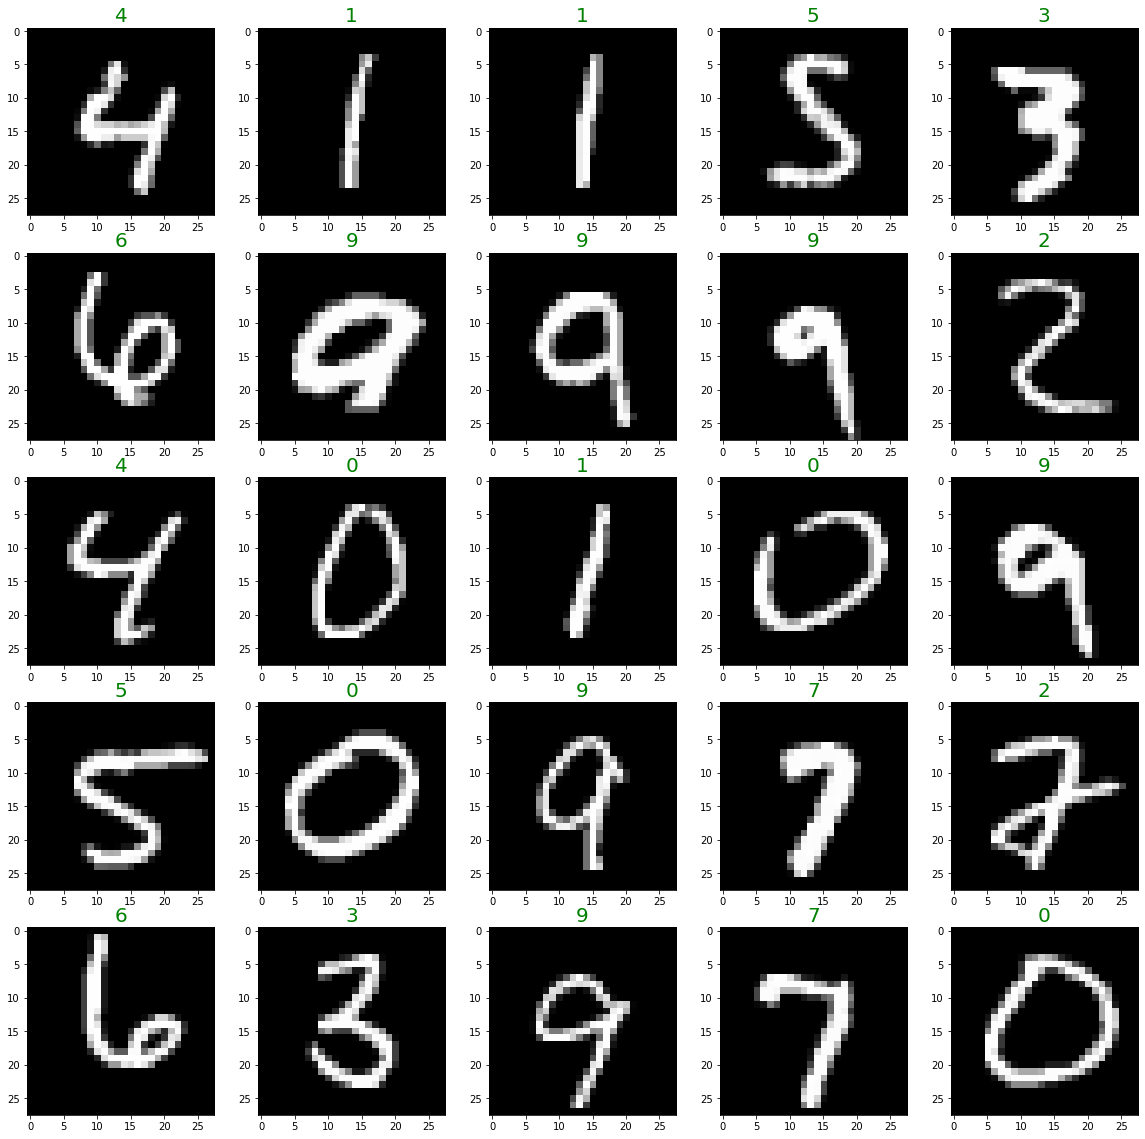

In [39]:
show_results(test_images, test_labels, preds, tipo = "acertos")

### Erros

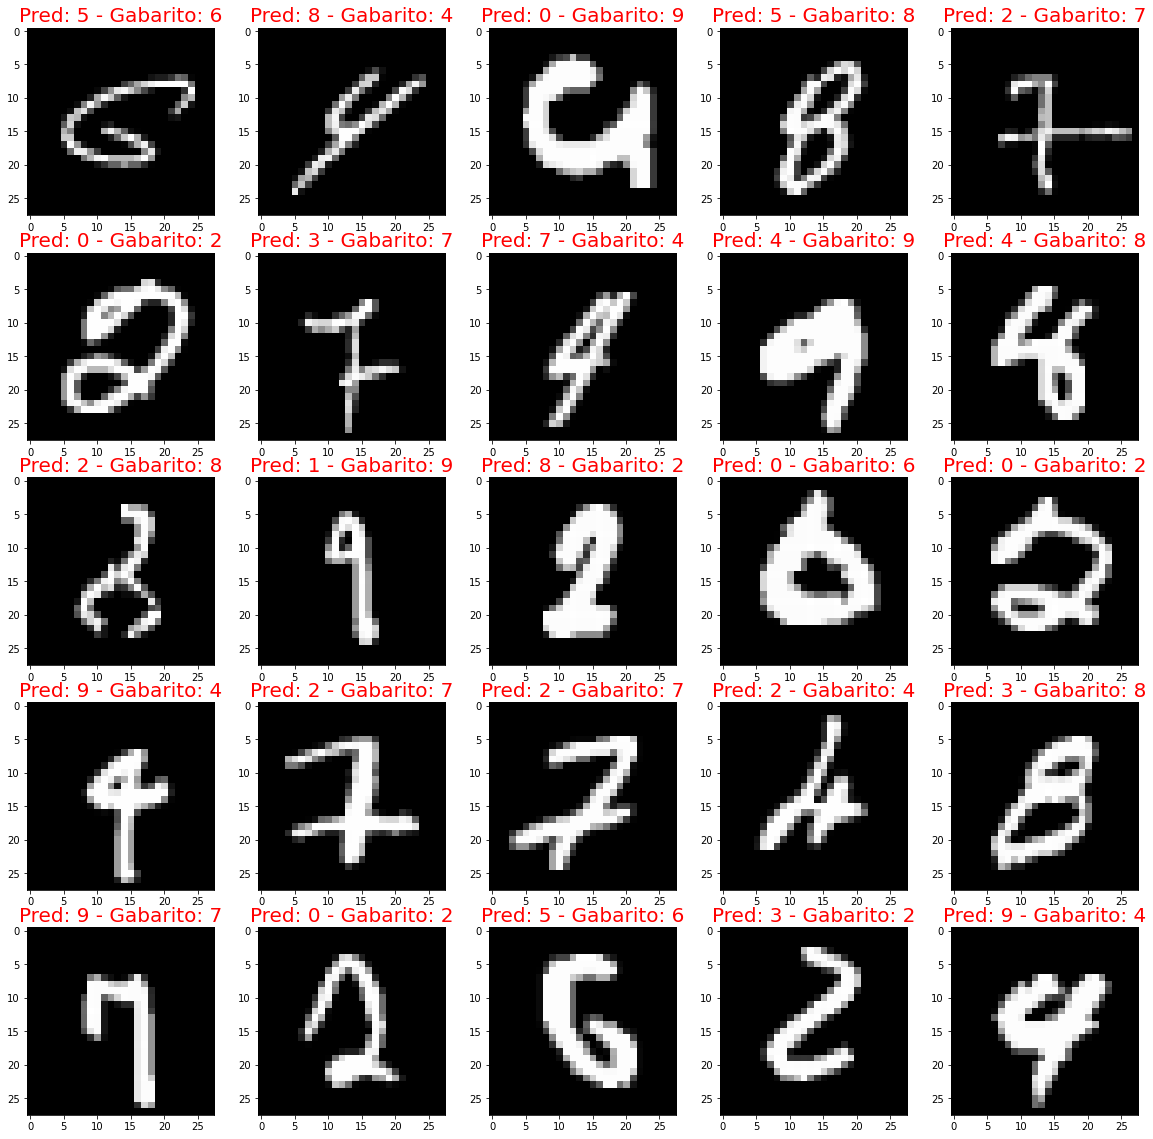

In [40]:
show_results(test_images, test_labels, preds, tipo = "erros")